![](../logo.png)

# Gamma regression
## Yoav Ram

We will develop a new GLM model using the Gamma distribution. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
from jax.scipy.stats import gamma
from scipy import optimize
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Data: Palmer penguins

The [Palmer penguins dataset](http://dx.doi.org/10.32614/RJ-2022-020) includes body size measurements collected from 2007-2009 for three species of Pygoscelis penguins that breed on islands throughout the Palmer Archipelago, Antarctica.

![](https://miro.medium.com/v2/resize:fit:1200/1*KAWxtQmdOg3XXOZwIJnMVA.png)

We install a Python package, `palmerpenguins` and use it to load the dataset.

In [2]:
!pip install palmerpenguins

In [3]:
from palmerpenguins import load_penguins

In [4]:
df = load_penguins()
df = df.dropna(subset=['body_mass_g', 'bill_length_mm', 'bill_depth_mm', 'island'])
df['species'] = pd.Categorical(df['species'])
df['island'] = pd.Categorical(df['island'])
df['sex'] = pd.Categorical(df['sex']).codes
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,1,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,1,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,1,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,0,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,1,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,1,2009


Can we predict body mass based on bill length, bill depth, flipper length, species, and sex?

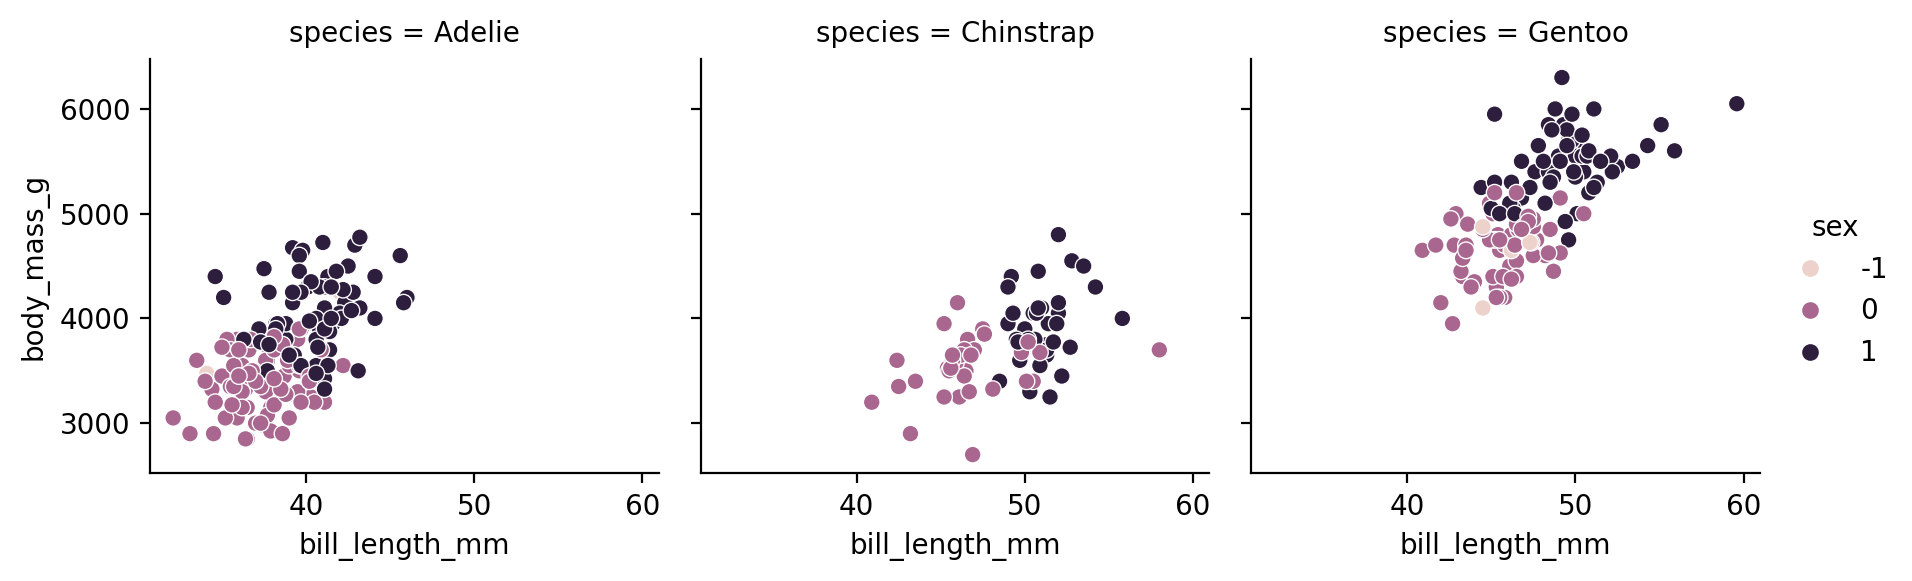

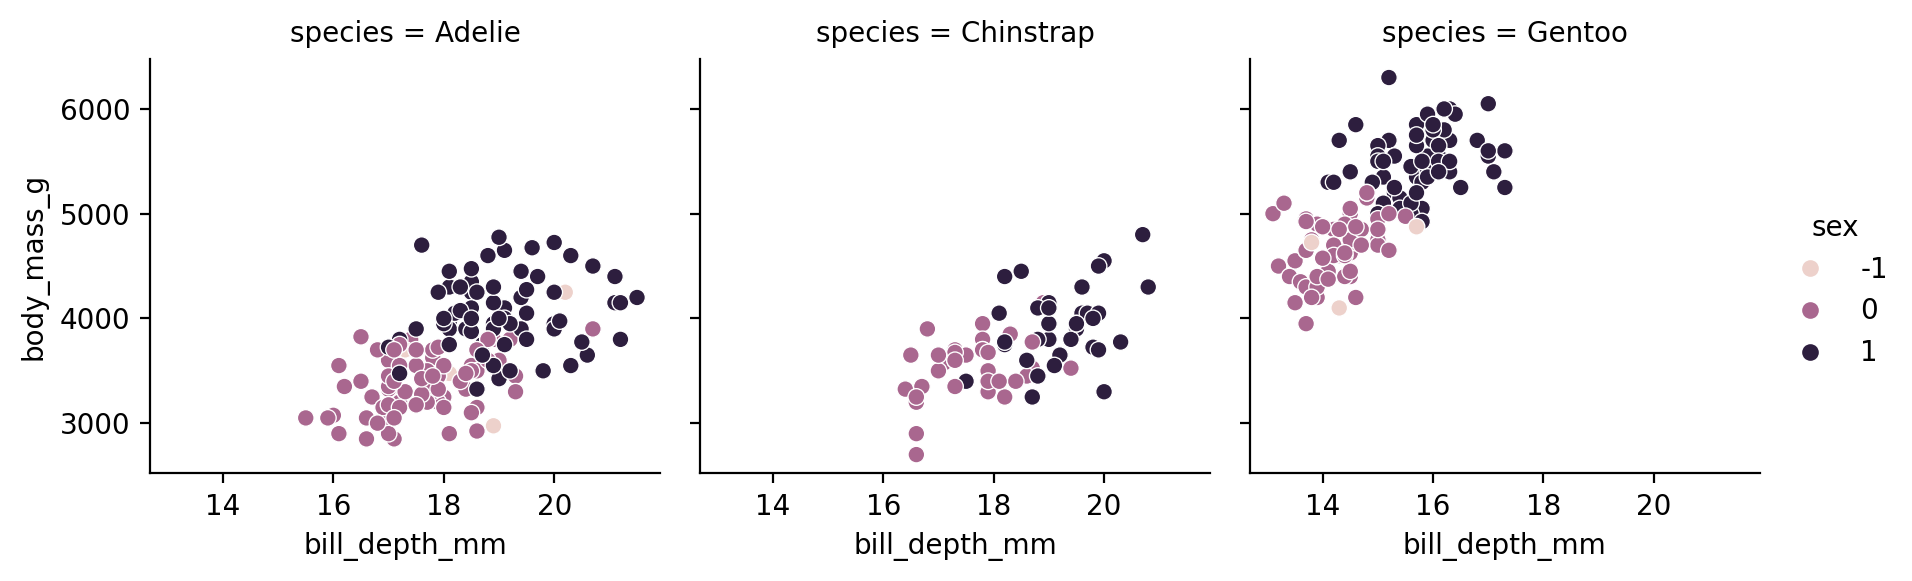

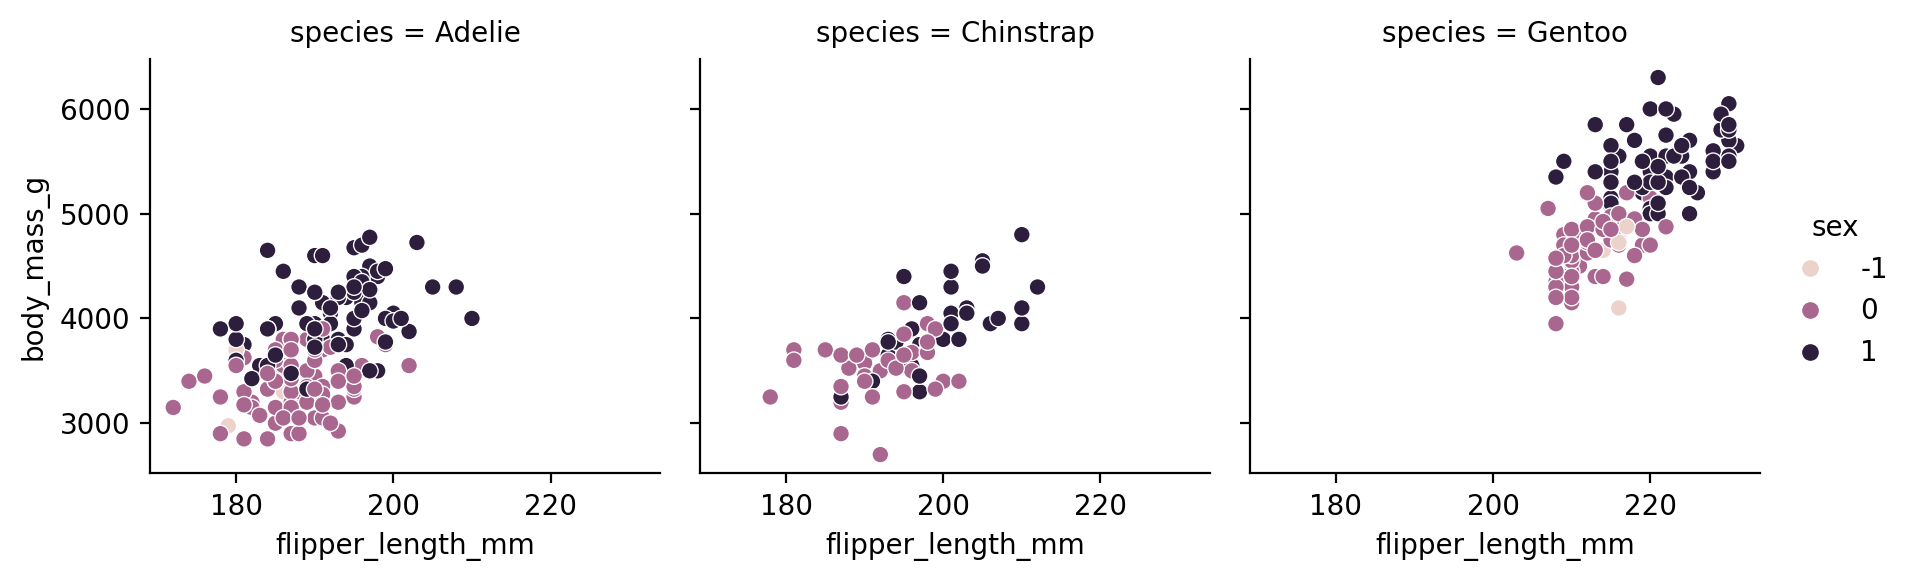

In [5]:
sns.relplot(df, x='bill_length_mm', y='body_mass_g', hue='sex', col='species', height=3)
sns.relplot(df, x='bill_depth_mm', y='body_mass_g', hue='sex', col='species', height=3);
sns.relplot(df, x='flipper_length_mm', y='body_mass_g', hue='sex', col='species', height=3);

Looks like we should be able to do it.

Before we start, we one-hot encode the species variable using `pd.get_dummies`.

In [6]:
df = pd.get_dummies(df, columns=['species'], dtype=float)
df.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,species_Adelie,species_Chinstrap,species_Gentoo
0,Torgersen,39.1,18.7,181.0,3750.0,1,2007,1.0,0.0,0.0
1,Torgersen,39.5,17.4,186.0,3800.0,0,2007,1.0,0.0,0.0
2,Torgersen,40.3,18.0,195.0,3250.0,0,2007,1.0,0.0,0.0
4,Torgersen,36.7,19.3,193.0,3450.0,0,2007,1.0,0.0,0.0
5,Torgersen,39.3,20.6,190.0,3650.0,1,2007,1.0,0.0,0.0


We grab the $X$ and $Y$, add a constant f or the intercept, and run the GLM from statsmodels.

In [7]:
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'species_Adelie', 'species_Chinstrap', 'species_Gentoo']].values
Y = df['body_mass_g'].values

# Gamma regression

We are going to use GLM to model the body mass.

We will use the **Gamma distribution** (ProbML 2.7.5), which is suitable for modeling positive continous variables when the _variance increases with the mean (heteroskedaticity)_. In contrast, in normal linear regression the variance $\sigma$ is constant.

The Gamma distribution $$X \sim \text{Gamma}(a,s)$$ has parameters: shape $a$ and scale $s$, which define the mean, $\mathbb{E}[X]=a s$, and variance, $\mathbb{V}[X] = a s^2$.

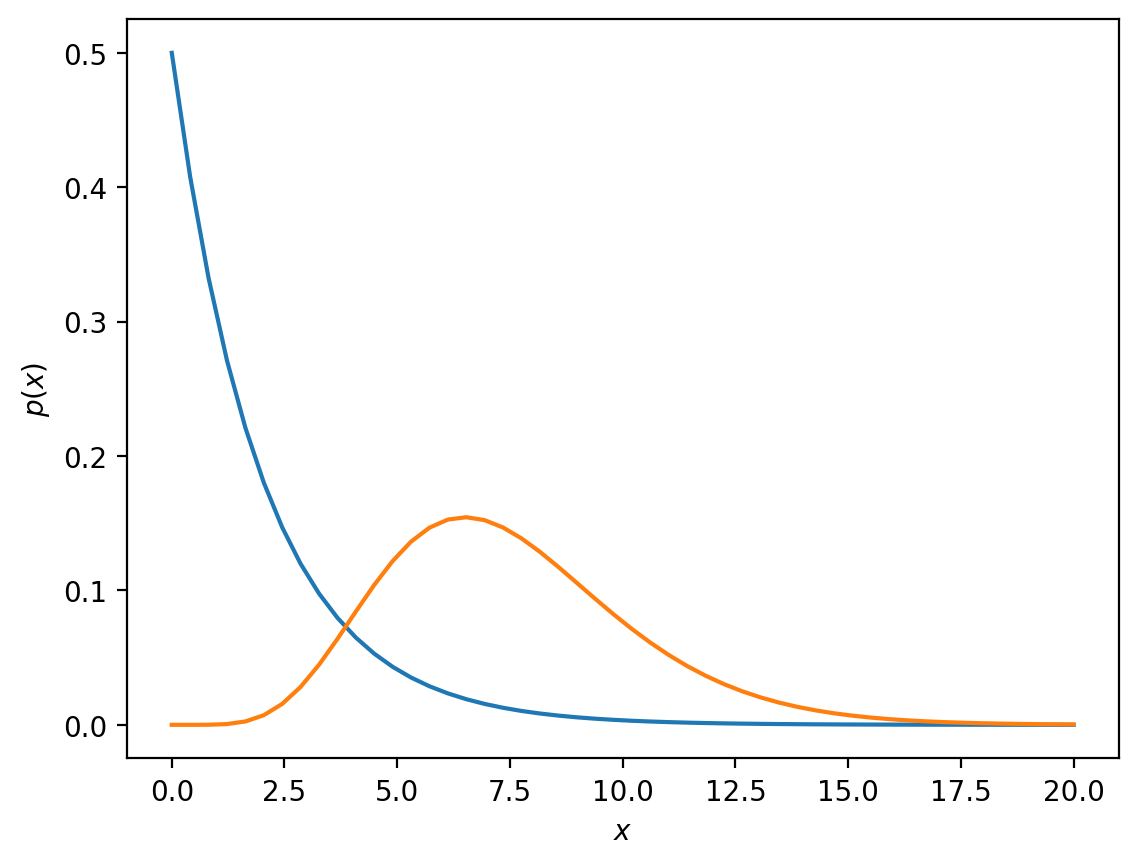

In [8]:
x_range = np.linspace(0, 20)
plt.plot(x_range, gamma.pdf(x_range, a=1, scale=2))
plt.plot(x_range, gamma.pdf(x_range, a=7.5, scale=1))
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

The model we are going to use is
$$
z_i = \sum_{j=1}^{m}{w_j \; x_{i,j}} $$$$
\hat{y}_i =  \exp{(z_i)} $$$$
y_i \sim \text{Gamma}(1/\varphi, \; \hat{y}_i \cdot \varphi)
$$
The parameterization with the shape $1/\varphi$ and scale $\hat{y}_i \cdot \varphi$ makes sure the expected value is $\mathbb{E}[Y_i]=\hat{y}_i$ and the variance $\mathbf{Var}[Y_i]= \varphi \hat{y}_i^2$ scales with (squared) expected value.

We use a log link function ($\hat{y}_i =  \exp{(z_i)}$) because the expected value has to be positive, as the Gamma distribution returns positive values.

In [9]:
def NLL(params, X, Y):
    W, logφ = params[:-1], params[-1]
    φ = np.exp(logφ)
    Z = X @ W
    Yhat = np.exp(Z)
    return -np.sum(gamma.logpdf(Y, a=1/φ, scale=Yhat*φ))

The minimization of the NLL is sensitive to the initial guess. To get a good initial guess, we solve the least squares (i.e., normal linear model) for $\log(Y)$ as a function of $X$.
We also guess that the scale is 0.1.

In [10]:
W0 = np.linalg.lstsq(X, np.log(Y), rcond=None)[0]
logφ0 = np.log(0.1)
params0 = np.concatenate([W0, np.array([logφ0])])
print('NLL with guess:', NLL(params0, X, Y))

NLL with guess: 2779.4773


Now we minimize the NLL!

We use Nelder-Mead method because other methods did not improve upon the initial guess.

In [11]:
result = optimize.minimize(
    NLL, 
    x0=params0,
    method='Nelder-Mead',
    args=(X, Y),
)
W_hat, φ_hat = result.x[:-1], np.exp(result.x[-1])
print(W_hat, φ_hat)
print('NLL with MLE:', result.fun)

[6.6391537e-03 2.7937919e-02 3.1601684e-03 5.8766603e-02 6.8148389e+00
 6.7368150e+00 7.0815129e+00] 0.0051367795
NLL with MLE: 2432.17333984375


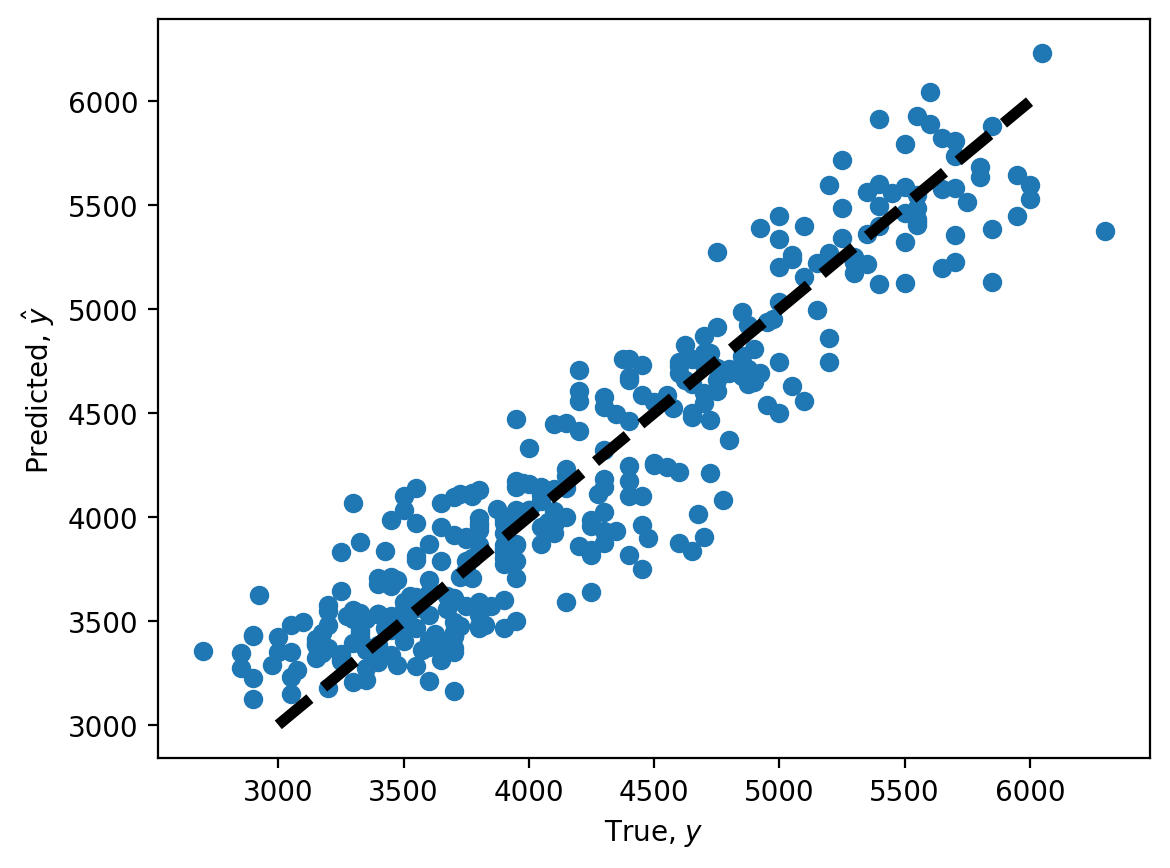

In [12]:
Z = X @ W_hat
Y_hat = np.exp(Z)
plt.scatter(df['body_mass_g'], Y_hat)
plt.plot(np.arange(3000, 6000), np.arange(3000, 6000), '--k', lw=4)
plt.xlabel('True, $y$')
plt.ylabel(r'Predicted, $\hat{y}$');

That's a pretty good fit.

# Statsmodels implementation

Of course, we don't have to implement it ourselves, we can use [Statsmodels's Gamma regression](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html#GLM:-Gamma-for-proportional-count-response).

We use the `GLM` model, with the `Gamma` family and the `Log` link function.

In [107]:
model = sm.GLM(Y, X, family=sm.families.Gamma(link=sm.families.links.Log()))
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:                            GLM   Df Residuals:                      335
Model Family:                   Gamma   Df Model:                            6
Link Function:                    Log   Scale:                       0.0052343
Method:                          IRLS   Log-Likelihood:                -2430.9
Date:                Mon, 24 Mar 2025   Deviance:                       1.7520
Time:                        20:48:00   Pearson chi2:                     1.75
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9970
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0053      0.002      3.013      0.003       0.002       0.009
x2             0.0230      0.005      4.883      0.000       0.014       0.032
x3             0.0036      0.001      5.029      0.000       0.002       0.005
x4             0.0706      0.010      7.068      0.000       0.051       0.090
x5             6.8638      0.137     50.147      0.000       6.596       7.132
x6             6.7953      0.143     47.407      0.000       6.514       7.076
x7             7.1121      0.152     46.866      0.000       6.815       7.410
==============================================================================
"""

Statsmodels says that all variables are significant (as P>0.05 and the confidence intervals do not include 0).

We can view the prediction error plot to see how good our model fit is.

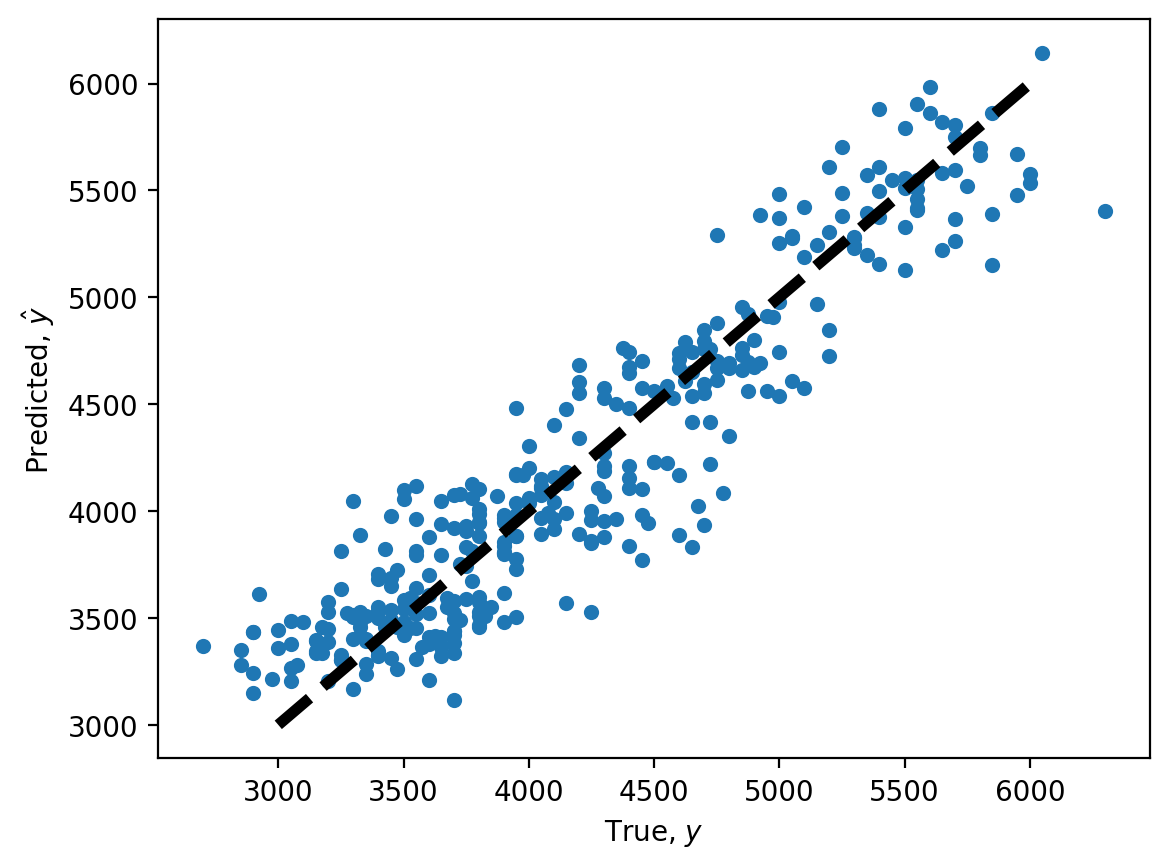

In [108]:
df['predicted_mass'] = model_result.predict(X)

df.plot.scatter('body_mass_g', 'predicted_mass')
plt.plot(np.arange(3000, 6000), np.arange(3000, 6000), '--k', lw=4)
plt.xlabel('True, $y$')
plt.ylabel(r'Predicted, $\hat{y}$');

Finally, compare our estimates with those of Statsmodels.

In [113]:
for i, (w1,w2) in enumerate(zip(W_hat, model_result.params)):
    print("W{}:\t{:.5f}\t{:.5f}".format(i, w1,w2))
print("scale:\t{:.5f}\t{:.5f}".format(ϕ_hat, model_result.scale))
print("Log likelihood:\t", -result.fun, model_result.llf)

W0:	0.00664	0.00526
W1:	0.02794	0.02295
W2:	0.00316	0.00364
W3:	0.05877	0.07061
W4:	6.81484	6.86383
W5:	6.73681	6.79535
W6:	7.08151	7.11208
scale:	0.00514	0.00523
Log likelihood:	 -2432.17333984375 -2430.9225938219633


# References

- [Scikit-learn Gamma regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html)
- [Is Gamma regression really useful?](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf) by Paul E. Johnson.
- - In All Likelihood by Yudi Pawitan, ch. 4.8; example 4.9.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)